In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import ndimage
import scipy
import glob
import os
import random

In [3]:
def read_and_grayscale_images(folderName, imgFolders, imgNames):
    image_dict={}
    color_img_dict={}

    for folder in imgFolders:
        image_list=[]
        color_list=[]
        for file in imgNames:
            path = folderName + folder +'/' + file   
            image = cv2.imread(path)
            image = cv2.resize(image,None,fx=scale[folder][0], fy=scale[folder][1], interpolation=cv2.INTER_CUBIC )
            imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
            color_list.append(image)
            image_list.append(gray)   
            
        image_dict[folder]= image_list
        color_img_dict[folder]=color_list
        
    return image_dict,color_img_dict

In [126]:
folderName = './images/'
imgFolders = ['Scene1'
              ,'Scene2'
              ,'Scene3','Scene4','Scene5'
             ]
imgNames = ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg','5.jpeg'] 

scale = {'Scene1':(0.3,0.3),'Scene2':(1,1),'Scene3':(0.3,0.3),
         'Scene4':(1,1),'Scene5':(0.3,0.3)
        }

In [5]:
def feature_detection(image):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    return kp, des

In [6]:
def feature_matching(img1, img2, num_iter=100,tolerance=2,threshold=0.8):
    
#     img1 --> right image
#     img2 --> left image
    
    kp1, des1 = feature_detection(img1)
    kp2, des2 = feature_detection(img2)
    
    dist = scipy.spatial.distance.cdist(des1,des2,'euclidean')    
    matches={}
    for i, des in enumerate(dist):
        val = np.argpartition(des, 2)[:2]
        matches[i,val[0],val[1]] = [des[val[0]],des[val[1]]]
    
    factor=0.5
    good_matches=[]
    for key in matches:
        if matches[key][0] < factor*matches[key][1]:
            good_matches.append((key[0],key[1]))

    if len(good_matches) > 12:
        point_pairs=[]
        for index_pair in good_matches:
            kp_img1 = kp1[index_pair[0]].pt
            kp_img2 = kp2[index_pair[1]].pt
            point_pairs.append((kp_img1,kp_img2))
            
        H,s = run_RANSAC(point_pairs,num_iter,tolerance,threshold)
        
    else:
        print("Not enough keypoints present")
        return 0
    
    return H, s

In [7]:
def findHomography(point_correspondances):
    n = len(point_correspondances)
    A = np.zeros((2*n,9))
    
    for i in range(n):
        x,y = point_correspondances[i][0]
        x_,y_ = point_correspondances[i][1]
        
        A[2*i+0:] = [x, y, 1, 0, 0, 0, -x_*x, -x_*y, -x_ ]
        A[2*i+1:] = [0, 0, 0, x, y, 1, -y_*x, -y_*y, -y_ ]

    U,D,V = np.linalg.svd(A, full_matrices= True)
    H = V[-1].reshape(3,3)
    
    if H[2,2]!=0:
        H /= H[2,2]
    
    return H

In [8]:
def findInliers(H, point_pairs, tolerance=2):
    inliers=[]
    for pt in point_pairs:
        x, y = pt[0]
        x_ , y_ = pt[1]
        
        norm_src_pt = np.array([x, y, 1]).T
        norm_des_pt = np.array([x_, y_, 1])   
        transformed_src_pt = np.matmul(H,norm_src_pt)  
        
        if transformed_src_pt[2]!=0:
            transformed_src_pt /= transformed_src_pt[2]
        
        if np.linalg.norm(transformed_src_pt - norm_des_pt)<=tolerance:
            inliers.append(pt)
            
    return inliers    

In [9]:
def run_RANSAC(point_pairs, num_iter=100, tolerance=2, threshold=0.8):

    inliers_lst = []
    inliers_count =[]

    for i in range(num_iter):
        point_correspondances = random.choices(point_pairs, k=4)
        H = findHomography(point_correspondances)
        s = findInliers(H,point_pairs,tolerance)
        inliers_lst.append(s)
        inliers_count.append(len(s))
        
        if len(s) >= int(threshold*len(point_pairs)):
            H_ = findHomography(s)
            return (H_,s)
        
    inliers_max = inliers_count.index(max(inliers_count))
        
    s = inliers_lst[inliers_max]
    H_ = findHomography(s)

    return (H_,s)

In [10]:
def warp_image(image,H):
    shape_x , shape_y = image.shape
    map_coord={}
    
    Xmin, Xmax = 10000, 0
    Ymin, Ymax = 10000, 0
    
    for i in range(shape_x):
        for j in range(shape_y):
            src_pt = np.array([j,i,1]).T
            transf_src_pt = np.matmul(H,src_pt)
            transf_src_pt/=transf_src_pt[2]
            
            map_coord[(i,j)] = (int(transf_src_pt[1]),int(transf_src_pt[0]))
            
            if int(transf_src_pt[1]) < Xmin:
                Xmin = int(transf_src_pt[0])
            if int(transf_src_pt[1]) > Xmax:
                Xmax = int(transf_src_pt[0])
            if int(transf_src_pt[0]) < Ymin:
                Ymin = int(transf_src_pt[1])
            if int(transf_src_pt[0]) > Ymax:
                Ymax = int(transf_src_pt[1])

    return map_coord, Xmin, Xmax, Ymin, Ymax

In [11]:
def find_mapping(images,num_iter,tolerance,threshold):
    
    H12, s12 = feature_matching(images[2], images[1],num_iter,tolerance,threshold)
    H23, s23 = feature_matching(images[3], images[2],num_iter,tolerance,threshold)
    H21 = np.linalg.inv(H12)
    
    print("one third done")
    
    H01, s01 = feature_matching(images[1], images[0],num_iter,tolerance,threshold)
    H34, s34 = feature_matching(images[4], images[3],num_iter,tolerance,threshold)    
    H10 = np.linalg.inv(H01)
    H20 = np.dot(H21, H10)
    H24 = np.dot(H23, H34)
   
    print("two third done")

    
    map_coord_21 ,Xmin_21, Xmax_21, Ymin_21, Ymax_21= warp_image(images[1], H21)
    map_coord_23 ,Xmin_23, Xmax_23, Ymin_23, Ymax_23= warp_image(images[3], H23)
    map_coord_20,Xmin_20, Xmax_20, Ymin_20, Ymax_20 = warp_image(images[0], H20)
    map_coord_24 ,Xmin_24, Xmax_24, Ymin_24, Ymax_24= warp_image(images[4], H24)

    print("map_coord done")

    Xmin = min(Xmin_21,Xmin_23,Xmin_20,Xmin_24)
    Xmax = max(Xmax_21,Xmax_23,Xmax_20,Xmax_24)
    Ymin = min(Ymin_21,Ymin_23,Ymin_20,Ymin_24)
    Ymax = max(Ymax_21,Ymax_23,Ymax_20,Ymax_24)
    
    return map_coord_21, map_coord_23, map_coord_20, map_coord_24, Xmin, Xmax, Ymin, Ymax

In [12]:
def panorama(images, colorimages, mapping_21, mapping_23, mapping_20, mapping_24
             , canvas_x,canvas_y,x_off,y_off
            ):
   
    shape_x, shape_y = images[0].shape
    canvas = np.zeros((canvas_x, canvas_y,3), dtype=np.uint8)
    print("canvas initialized")
    
#     print(canvas_x,canvas_y,x_off,y_off)
    
    for i in range(images[0].shape[0]):
        for j in range(images[0].shape[1]):
            for d1 in range(-2,3):
                for d2 in range(-2,3):
                    x = mapping_20[(i, j)][0]
                    y = mapping_20[(i, j)][1]
                    canvas[x + x_off + d1, y +y_off + d2] = (colorimages[0][i, j])

    print("first image done")
    
    for i in range(images[1].shape[0]):
        for j in range(images[1].shape[1]):
            for d1 in range(-1,2):
                for d2 in range(-1,2):
                    x = mapping_21[(i, j)][0]
                    y = mapping_21[(i, j)][1]
                    canvas[x + x_off + d1, y +y_off + d2] = (colorimages[1][i, j])

    print("second image done")
    
    for i in range(images[2].shape[0]):
        for j in range(images[2].shape[1]):
            canvas[i + x_off, j +y_off] = colorimages[2][i, j]
    
    print("third image done")
                    
    for i in range(images[3].shape[0]):
        for j in range(images[3].shape[1]):
            for d1 in range(-1,2):
                for d2 in range(-1,2):
                    x = mapping_23[(i, j)][0]
                    y = mapping_23[(i, j)][1]
                    canvas[x + x_off + d1, y +y_off + d2] = (colorimages[3][i, j])
                    
    print("fouth image done")
    
    for i in range(images[4].shape[0]):
        for j in range(images[4].shape[1]):
            for d1 in range(-2,3):
                for d2 in range(-2,3):
                    x = mapping_24[(i, j)][0]
                    y = mapping_24[(i, j)][1]
                    canvas[x + x_off + d1, y +y_off + d2] = (colorimages[4][i, j])
    
    print("fifth image done")
               
    return canvas

In [13]:
def in_built_function_implementation(img1, img2):
    kp1, des1 = feature_detection(img1)
    kp2, des2 = feature_detection(img2)

    bf = cv2.BFMatcher(normType = cv2.NORM_L2)
    matches = bf.knnMatch(des1,des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5*n.distance:
            good_matches.append(m)
    good_matches = np.asarray(good_matches)
    
    if len(good_matches) > 12:
        src = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        H, s = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    
    return H,s

In [14]:
def using_warpPerspective(colorimages):
    
    img0,img1,img2,img3,img4 = colorimages

    H34, s34 = in_built_function_implementation(colorimages[4],colorimages[3] )
    img34=cv2.warpPerspective(img4,H34,(img3.shape[1] + img4.shape[1], img3.shape[0]))
    img34[0:img3.shape[0], 0:img3.shape[1]] = img3
    img34=trim(img34)
    
    print("two images done")
    
    H234, s234 = in_built_function_implementation(img34, colorimages[2])
    img234=cv2.warpPerspective(img34,H234,(img2.shape[1] + img34.shape[1], img2.shape[0]))
    img234[0:img2.shape[0], 0:img2.shape[1]] = img2
    img234=trim(img234)
    
    print("three images done")
    
    H1234, s1234 = in_built_function_implementation(img234, colorimages[1])
    img1234=cv2.warpPerspective(img234,H1234,(img1.shape[1] + img234.shape[1], img1.shape[0]))
    img1234[0:img1.shape[0], 0:img1.shape[1]] = img1
    img1234=trim(img1234)
    
    print("four images done")
    
    H01234, s01234 = in_built_function_implementation(img1234, colorimages[0])
    img01234=cv2.warpPerspective(img1234,H01234,(img0.shape[1] + img1234.shape[1], img0.shape[0]))
    img01234[0:img0.shape[0], 0:img0.shape[1]] = img0
    img01234=trim(img01234)
    
    print("five images done")
    
    return img01234

In [15]:
def trim(img):
    if not np.sum(img[0]):
        return trim(img[1:])
    if not np.sum(img[-1]):
        return trim(img[:-2])
    if not np.sum(img[:,0]):
        return trim(img[:,1:])
    if not np.sum(img[:,-1]):
        return trim(img[:,:-2])
    return img

In [127]:
image_dict, color_img_dict = read_and_grayscale_images(folderName, imgFolders, imgNames)

# Scene 1

In [94]:
Scene = 'Scene1'
images = image_dict[Scene]
colorimages = color_img_dict[Scene]

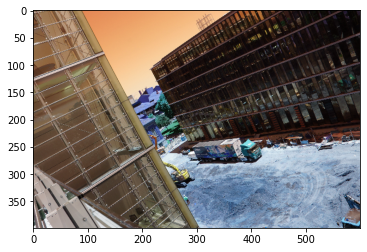

In [95]:
plt.imshow(color_img_dict[Scene][2])
plt.show()

In [96]:
print("shape of images: ",image_dict[Scene][2].shape)

shape of images:  (399, 600)


### Implementing from scratch

In [97]:
num_iter=100
tolerance=2
threshold=0.8

In [98]:
map_coord_21, map_coord_23, map_coord_20, map_coord_24, Xmin, Xmax, Ymin, Ymax= find_mapping(images,num_iter,tolerance,threshold)

one third done
two third done
map_coord done


In [99]:
print(Xmin, Xmax, Ymin, Ymax)

-533 1113 27 591


In [103]:
canvas_x,canvas_y= 2000, 2000
x_off ,y_off = int(1000), int(-1300)

In [104]:
canvas = panorama(images, colorimages, map_coord_21, map_coord_23, map_coord_20, map_coord_24, canvas_x,canvas_y,x_off,y_off)

canvas initialized
first image done
second image done
third image done
fouth image done
fifth image done


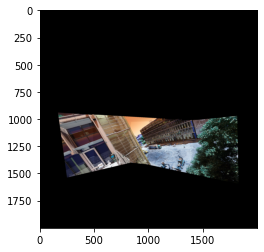

In [105]:
plt.imshow(canvas)
plt.show()

In [106]:
canvas = trim(canvas)

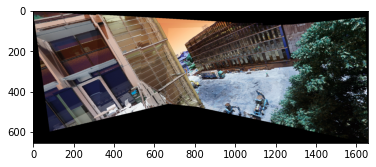

True

In [107]:
plt.imshow(canvas)
plt.show()
cv2.imwrite("results/Scene1_scratch.jpg",canvas)

### Using Inbuilt Implementation

In [108]:
canvas_inbuilt = using_warpPerspective(colorimages)

two images done
three images done
four images done
five images done


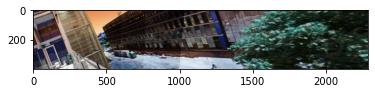

True

In [109]:
plt.imshow(canvas_inbuilt)
plt.show()
cv2.imwrite("results/Scene1_inbuilt.jpg",canvas_inbuilt)

# Scene 2

In [110]:
Scene = 'Scene2'
images = image_dict[Scene]
colorimages = color_img_dict[Scene]

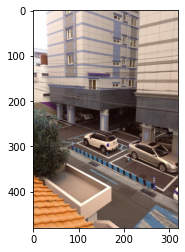

In [111]:
plt.imshow(color_img_dict[Scene][2])
plt.show()

In [112]:
print("shape of images: ",image_dict[Scene][2].shape)

shape of images:  (480, 320)


### Implementation from scratch

In [113]:
num_iter=100
tolerance=2
threshold=0.8

In [114]:
map_coord_21, map_coord_23, map_coord_20, map_coord_24, Xmin, Xmax, Ymin, Ymax= find_mapping(images,num_iter,tolerance,threshold)

one third done
two third done
map_coord done


In [115]:
print(Xmin, Xmax, Ymin, Ymax)

-468 549 20 554


In [116]:
canvas_x,canvas_y= 1500, 1500
x_off ,y_off = int(200), int(-1000)

In [117]:
canvas = panorama(images, colorimages, map_coord_21, map_coord_23, map_coord_20, map_coord_24, canvas_x,canvas_y,x_off,y_off)

canvas initialized
first image done
second image done
third image done
fouth image done
fifth image done


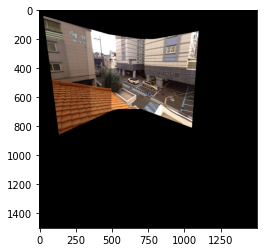

In [118]:
plt.imshow(canvas)
plt.show()

In [119]:
canvas = trim(canvas)

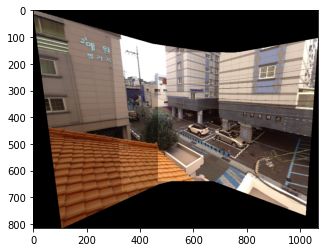

True

In [120]:
plt.imshow(canvas)
plt.show()
cv2.imwrite("results/Scene2_scratch.jpg",canvas)

### Using Inbuilt Implementation

In [121]:
canvas_inbuilt = using_warpPerspective(colorimages)

two images done
three images done
four images done
five images done


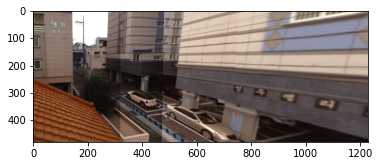

True

In [122]:
plt.imshow(canvas_inbuilt)
plt.show()
cv2.imwrite("results/Scene2_inbuilt.jpg",canvas_inbuilt)

# Scene 3

In [128]:
Scene = 'Scene3'
images = image_dict[Scene]
colorimages = color_img_dict[Scene]

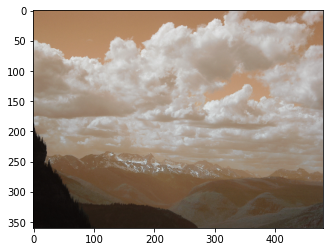

In [129]:
plt.imshow(color_img_dict[Scene][2])
plt.show()

In [130]:
print("shape of images: ",image_dict[Scene][2].shape)

shape of images:  (360, 480)


### Implementation from scratch

In [131]:
num_iter=100
tolerance=2
threshold=0.8

In [132]:
map_coord_21, map_coord_23, map_coord_20, map_coord_24, Xmin, Xmax, Ymin, Ymax= find_mapping(images,num_iter,tolerance,threshold)

one third done
two third done
map_coord done


In [133]:
print(Xmin, Xmax, Ymin, Ymax)

-269 586 12 383


In [140]:
canvas_x,canvas_y= 1500, 1500
x_off ,y_off = int(700), int(-900)

In [141]:
canvas = panorama(images, colorimages, map_coord_21, map_coord_23, map_coord_20, map_coord_24, canvas_x,canvas_y,x_off,y_off)

canvas initialized
first image done
second image done
third image done
fouth image done
fifth image done


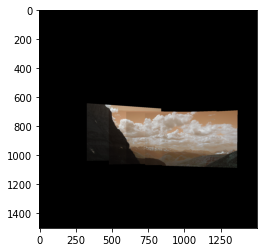

In [142]:
plt.imshow(canvas)
plt.show()

In [143]:
canvas = trim(canvas)

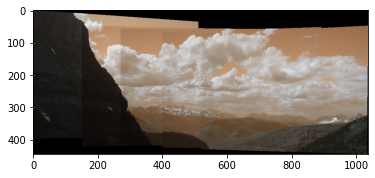

True

In [144]:
plt.imshow(canvas)
plt.show()
cv2.imwrite("results/Scene3_scratch.jpg",canvas)

### Using Inbuilt Implementation

In [145]:
canvas_inbuilt = using_warpPerspective(colorimages)

two images done
three images done
four images done
five images done


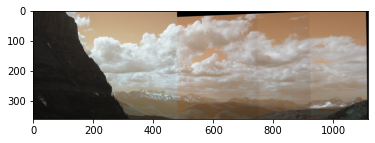

True

In [146]:
plt.imshow(canvas_inbuilt)
plt.show()
cv2.imwrite("results/Scene3_inbuilt.jpg",canvas_inbuilt)

# Scene 4

In [147]:
Scene = 'Scene4'
images = image_dict[Scene]
colorimages = color_img_dict[Scene]

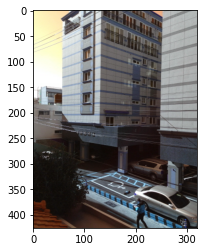

In [148]:
plt.imshow(color_img_dict[Scene][2])
plt.show()

In [149]:
print("shape of images: ",image_dict[Scene][2].shape)

shape of images:  (426, 320)


### Implementation from scratch

In [150]:
num_iter=100
tolerance=2
threshold=0.8

In [151]:
map_coord_21, map_coord_23, map_coord_20, map_coord_24, Xmin, Xmax, Ymin, Ymax= find_mapping(images,num_iter,tolerance,threshold)

one third done
two third done
map_coord done


In [152]:
print(Xmin, Xmax, Ymin, Ymax)

-774 1077 -5 735


In [153]:
canvas_x,canvas_y= 1500, 2000
x_off ,y_off = int(500), int(-1200)

In [154]:
canvas = panorama(images, colorimages, map_coord_21, map_coord_23, map_coord_20, map_coord_24, canvas_x,canvas_y,x_off,y_off)

canvas initialized
first image done
second image done
third image done
fouth image done
fifth image done


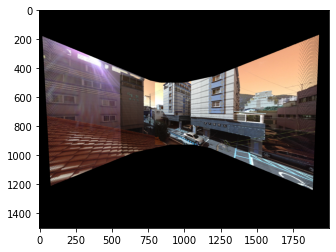

In [155]:
plt.imshow(canvas)
plt.show()

In [156]:
canvas = trim(canvas)

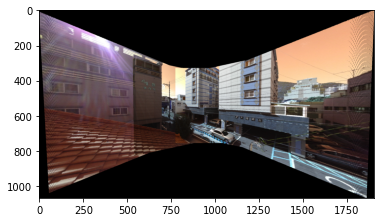

True

In [157]:
plt.imshow(canvas)
plt.show()
cv2.imwrite("results/Scene4_scratch.jpg",canvas)

### Using Inbuilt Implementation

In [158]:
canvas_inbuilt = using_warpPerspective(colorimages)

two images done
three images done
four images done
five images done


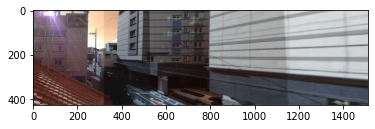

True

In [159]:
plt.imshow(canvas_inbuilt)
plt.show()
cv2.imwrite("results/Scene4_inbuilt.jpg",canvas_inbuilt)

# Scene 5

In [160]:
Scene = 'Scene5'
images = image_dict[Scene]
colorimages = color_img_dict[Scene]

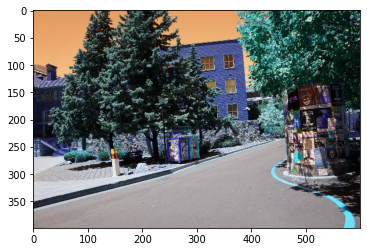

In [161]:
plt.imshow(color_img_dict[Scene][2])
plt.show()

In [162]:
print("shape of images: ",image_dict[Scene][2].shape)

shape of images:  (399, 600)


### Implementation from scratch

In [163]:
num_iter=100
tolerance=2
threshold=0.8

In [164]:
map_coord_21, map_coord_23, map_coord_20, map_coord_24, Xmin, Xmax, Ymin, Ymax= find_mapping(images,num_iter,tolerance,threshold)

one third done
two third done
map_coord done


In [165]:
print(Xmin, Xmax, Ymin, Ymax)

-722 1393 20 552


In [166]:
canvas_x,canvas_y= 2000, 2500
x_off ,y_off = int(1000), int(-1550)

In [167]:
canvas = panorama(images, colorimages, map_coord_21, map_coord_23, map_coord_20, map_coord_24, canvas_x,canvas_y,x_off,y_off)

canvas initialized
first image done
second image done
third image done
fouth image done
fifth image done


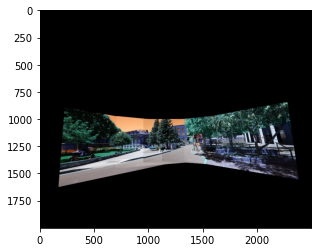

In [168]:
plt.imshow(canvas)
plt.show()

In [169]:
canvas = trim(canvas)

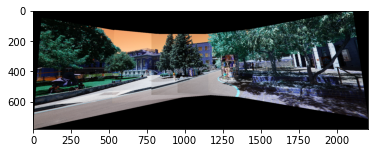

True

In [170]:
plt.imshow(canvas)
plt.show()
cv2.imwrite("results/Scene5_scratch.jpg",canvas)

### Using Inbuilt Implementation

In [171]:
canvas_inbuilt = using_warpPerspective(colorimages)

two images done
three images done
four images done
five images done


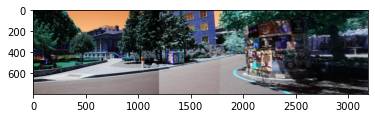

True

In [172]:
plt.imshow(canvas_inbuilt)
plt.show()
cv2.imwrite("results/Scene5_inbuilt.jpg",canvas_inbuilt)